In [1]:
import os
import sys
homedir = os.getenv("USERPROFILE") if sys.platform=='win32' else os.getenv("HOME")

In [2]:
from collections import OrderedDict
import os.path as op

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance

factory_dir = op.join(homedir, "repos", "hybridfactory")
if not factory_dir in sys.path:
    sys.path.insert(0, factory_dir)

import factory.io.gt
import factory.io.jrc
import factory.io.phy
import factory.io.raw

import factory.probes.eMouse as eMouse
import factory.probes.npix3a as npix3a
import factory.probes.hh2_arseny as hh2_arseny

C:\Users\Alan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%matplotlib notebook

In [4]:
def channel_coordinates(channels, probe):
    if not hasattr(channels, "__len__"):
        channels = np.array([channels])
    elif not isinstance(channels, np.ndarray):
        channels = np.array(channels)
        
    coords = np.zeros((channels.size, 2))
    for i, c in enumerate(channels):
        coords[i, :] = probe.channel_positions[probe.channel_map == c]
    
    return coords

def coordinate_channels(coords, probe):
    channels = np.zeros(coords.shape[0], dtype=probe.channel_map.dtype)
    
    for i, xy in enumerate(coords):
        channels[i] = probe.channel_map[np.all(probe.channel_positions == xy, axis=1)][0]
        
    return channels

def furthest_from(reference, subset, probe):
    if len(reference.shape) < 2:
        reference = reference[np.newaxis, :]
    
    subset_positions = probe.channel_positions[np.isin(probe.channel_map, subset), :]
    ai = scipy.spatial.distance.cdist(reference, subset_positions).ravel().argmax()
    anchor = probe.channel_map[np.isin(probe.channel_map, subset)][ai]
    
    return anchor

def find_neighbors(subset, probe):
    probe_positions = probe.channel_positions[probe.connected, :]
    probe_channels = probe.channel_map[probe.connected]
    probe_center = probe_positions.mean(axis=0)
    
    anchor = furthest_from(probe_center, subset, probe)
    anchor_coords = channel_coordinates(anchor, probe)
    dist_relations = channel_coordinates(subset, probe) - anchor_coords

    matches = {}
    for candidate in probe_channels:
        if candidate == anchor:
            continue
        candidate_dist_relations = probe_positions - channel_coordinates(candidate, probe)
        candidate_channels = -np.ones_like(subset)
        
        for i, dr in enumerate(dist_relations):
            dr_matches = np.all(candidate_dist_relations == dr, axis=1)
            if not dr_matches.any():  # no match in this relation
                break
            else:
                candidate_channels[i] = probe_channels[np.where(dr_matches)[0][0]]
        # did we survive?
        if np.count_nonzero(candidate_channels == -1) > 0:
            continue
        else:
            matches[candidate] = candidate_channels
            
    # now sort these in order
    match_keys = np.array(list(matches.keys()))
    match_dists = scipy.spatial.distance.cdist(anchor_coords, channel_coordinates(match_keys, probe)).ravel()
    
    match_order = match_dists.argsort()
    
    return OrderedDict([(k, matches[k]) for k in match_keys[match_order]])

## eMouse probe (from KiloSort)

First load up some data from the probe file.

In [5]:
eMouse_positions = eMouse.channel_positions[eMouse.connected, :]
eMouse_channels = eMouse.channel_map[eMouse.connected]
assert (~np.isnan(eMouse_positions)).all()

eMouse_center = eMouse_positions.mean(axis=0)
eMouse_subset = np.array([3,4,5,1,2,30,0])

eMouse_x, eMouse_y = eMouse_positions.T
eMouse_subset_x, eMouse_subset_y = channel_coordinates(eMouse_subset, eMouse).T

Now let's randomly select a set of shifted channels which match our spatial distribution. We'll bias the sample in favor of channels which are further away.

In [6]:
np.random.seed(10191)

eMouse_shift_candidates = find_neighbors(eMouse_subset, eMouse)

# bias in favor of channels further out
eMouse_weights = 1 + np.arange(len(eMouse_shift_candidates), dtype=np.float64)
eMouse_weights /= eMouse_weights.sum()
eMouse_anchor = np.random.choice(list(eMouse_shift_candidates.keys()), p=eMouse_weights)

eMouse_shifted_channels = eMouse_shift_candidates[eMouse_anchor]

Now let's plot our original channels as yellow stars and our shifted channels as red octagons.

<IPython.core.display.Javascript object>


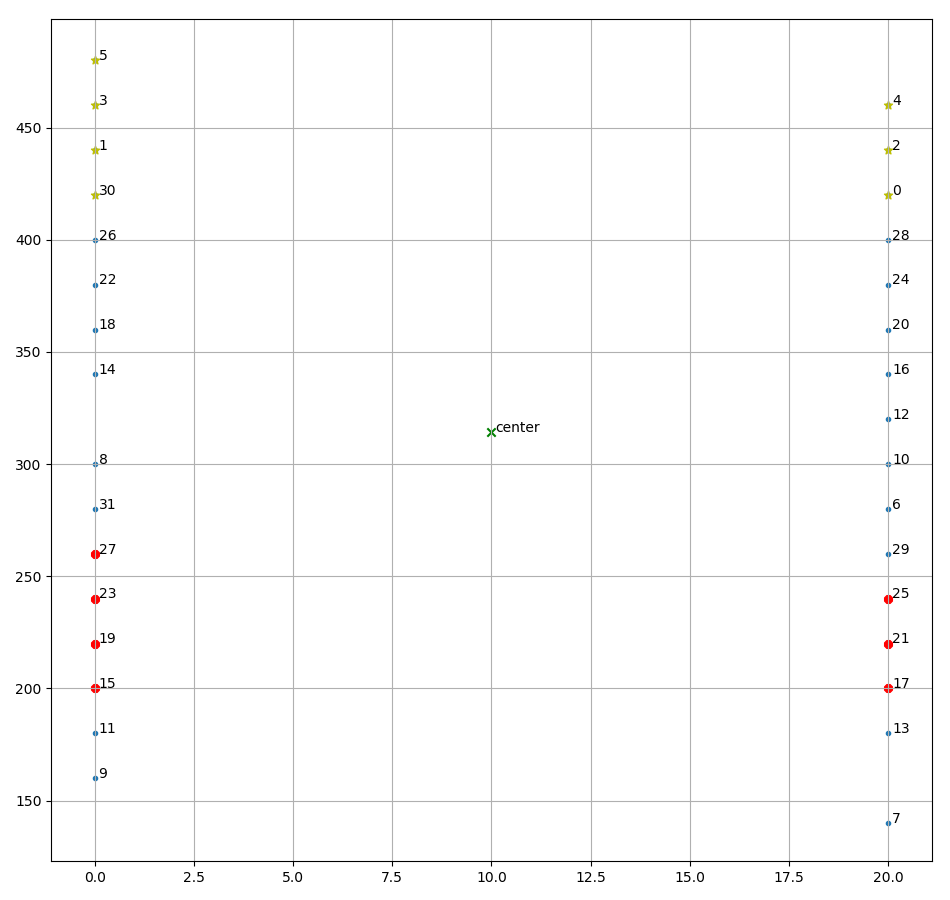

In [7]:
eMouse_shifted_x, eMouse_shifted_y = channel_coordinates(eMouse_shifted_channels, eMouse).T

fig = plt.figure(figsize=(9.5, 9))
ax = fig.gca()
ax.scatter(eMouse_x, eMouse_y, marker='.')

for k, xy in enumerate(zip(eMouse_x + 0.1, eMouse_y + 0.1)):
    ax.annotate(f"{eMouse_channels[k]}", xy=xy, textcoords='data')

ax.scatter(eMouse_center[0], eMouse_center[1], marker='x', color='g')
ax.annotate("center", xy=eMouse_center + 0.1)

ax.scatter(eMouse_subset_x, eMouse_subset_y, marker='*', color='y')
ax.scatter(eMouse_shifted_x, eMouse_shifted_y, marker='8', color='r')

ax.grid()
    
fig.tight_layout()

## hh2_arseny probe (from JRCLUST)

In [8]:
hh2_arseny_positions = hh2_arseny.channel_positions[hh2_arseny.connected, :]
hh2_arseny_channels = hh2_arseny.channel_map[hh2_arseny.connected]
assert (~np.isnan(hh2_arseny_positions)).all()

hh2_arseny_center = hh2_arseny_positions.mean(axis=0)
hh2_arseny_subset = np.array([78,79,96,97,126])

hh2_arseny_x, hh2_arseny_y = hh2_arseny_positions.T
hh2_arseny_subset_x, hh2_arseny_subset_y = channel_coordinates(hh2_arseny_subset, hh2_arseny).T

Now let's randomly select a set of shifted channels which match our spatial distribution. We'll bias the sample in favor of channels which are further away.

In [9]:
np.random.seed(13702)

hh2_arseny_shift_candidates = find_neighbors(hh2_arseny_subset, hh2_arseny)

# bias in favor of channels further out
hh2_arseny_weights = 1 + np.arange(len(hh2_arseny_shift_candidates), dtype=np.float64)
hh2_arseny_weights /= hh2_arseny_weights.sum()
hh2_arseny_anchor = np.random.choice(list(hh2_arseny_shift_candidates.keys()), p=hh2_arseny_weights)

hh2_arseny_shifted_channels = hh2_arseny_shift_candidates[hh2_arseny_anchor]

Now let's plot our original channels as yellow stars and our shifted channels as red octagons.

<IPython.core.display.Javascript object>


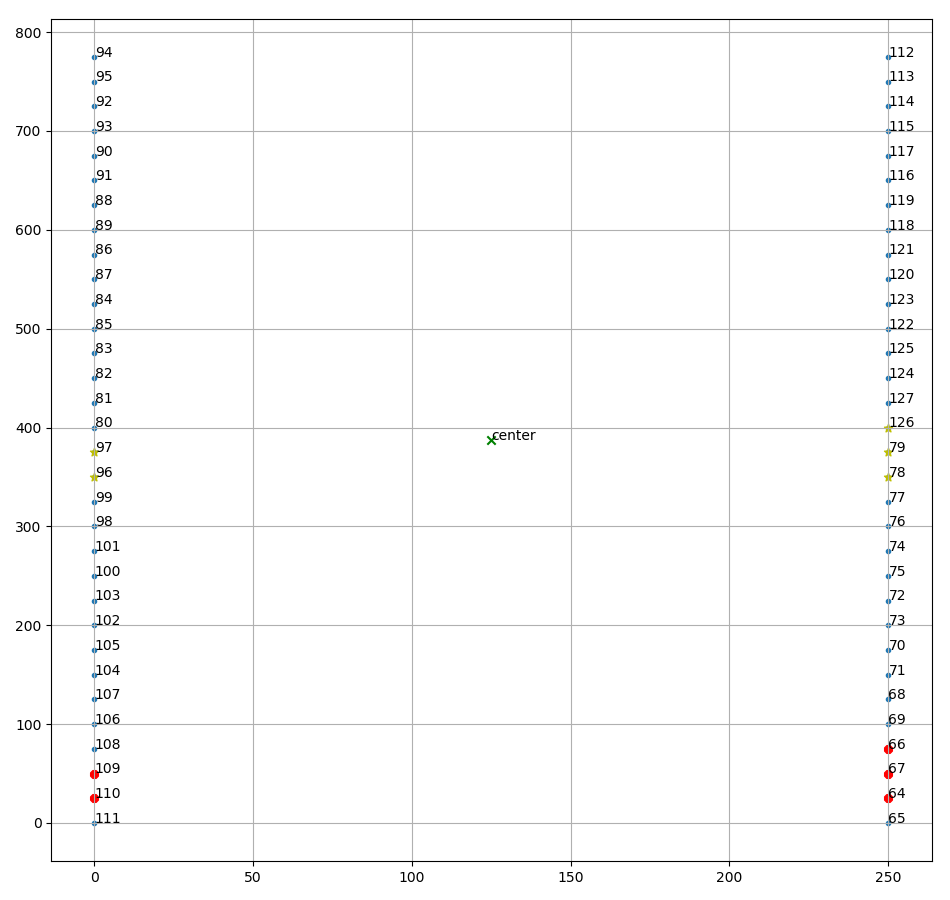

In [10]:
hh2_arseny_shifted_x, hh2_arseny_shifted_y = channel_coordinates(hh2_arseny_shifted_channels, hh2_arseny).T

fig = plt.figure(figsize=(9.5, 9))
ax = fig.gca()
ax.scatter(hh2_arseny_x, hh2_arseny_y, marker='.')

for k, xy in enumerate(zip(hh2_arseny_x + 0.1, hh2_arseny_y + 0.1)):
    ax.annotate(f"{hh2_arseny_channels[k]}", xy=xy, textcoords='data')

ax.scatter(hh2_arseny_center[0], hh2_arseny_center[1], marker='x', color='g')
ax.annotate("center", xy=hh2_arseny_center + 0.1)

ax.scatter(hh2_arseny_subset_x, hh2_arseny_subset_y, marker='*', color='y')
ax.scatter(hh2_arseny_shifted_x, hh2_arseny_shifted_y, marker='8', color='r')

ax.grid()
    
fig.tight_layout()

## Neuropixels 3A probe

First load up some data from the probe file.

In [11]:
npix3a_positions = npix3a.channel_positions[npix3a.connected, :]
npix3a_channels = npix3a.channel_map[npix3a.connected]
assert (~np.isnan(npix3a_positions)).all()

npix3a_center = npix3a_positions.mean(axis=0)
npix3a_subset = np.array([201,203,205,207,209,211])

npix3a_x, npix3a_y = npix3a_positions.T
npix3a_subset_x, npix3a_subset_y = channel_coordinates(npix3a_subset, npix3a).T

Now let's randomly select a set of shifted channels which match our spatial distribution. We'll bias the sample in favor of channels which are further away.

In [12]:
np.random.seed(13702)

npix3a_shift_candidates = find_neighbors(npix3a_subset, npix3a)

# bias in favor of channels further out
npix3a_weights = 1 + np.arange(len(npix3a_shift_candidates), dtype=np.float64)
npix3a_weights /= npix3a_weights.sum()
npix3a_anchor = np.random.choice(list(npix3a_shift_candidates.keys()), p=npix3a_weights)

npix3a_shifted_channels = npix3a_shift_candidates[npix3a_anchor]

Now let's plot our original channels as yellow stars and our shifted channels as red octagons.

In [13]:
npix3a_shifted_x, npix3a_shifted_y = channel_coordinates(npix3a_shifted_channels, npix3a).T

fig = plt.figure(figsize=(9.5, 9))
ax = fig.gca()
ax.scatter(npix3a_x, npix3a_y, marker='.')

for k, xy in enumerate(zip(npix3a_x + 0.1, npix3a_y + 0.1)):
    ax.annotate(f"{npix3a_channels[k]}", xy=xy, textcoords='data')

ax.scatter(npix3a_center[0], npix3a_center[1], marker='x', color='g')
ax.annotate("center", xy=npix3a_center + 0.1)

ax.scatter(npix3a_subset_x, npix3a_subset_y, marker='*', color='y')
ax.scatter(npix3a_shifted_x, npix3a_shifted_y, marker='8', color='r')

ax.grid()
    
fig.tight_layout()

<IPython.core.display.Javascript object>